In [53]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict, Counter
import random
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset

# VQVAE Implementation

In [27]:
with open("pkl files/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

In [28]:
# Importing models
from vqmodel import *

In [29]:
# Dataframe to tensor transition
images = []

for df in chunks:
    # df['ch'] is a Series of 80 columns; each item is a list of 200 values
    # Create a (200, 80) NumPy array (transpose is needed)
    matrix = np.stack(df['PWR_ch1'].to_list(), axis=1)  # shape: (200, 80)
    images.append(matrix)

# Convert the whole thing to numpy because making tensors from a list of arrays
# is extremely slow
images_array = np.array(images)


In [30]:
# Convert to torch tensor and add batch + channel dimensions
data_tensor = torch.tensor(images_array, dtype=torch.float32)  # (B, 200, 80)
data_tensor = data_tensor.unsqueeze(1)  # (B, 1, 200, 80)

In [31]:
from torch.utils.data import DataLoader

dataset = ChunkImageDataset(chunks)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE(in_channels=1)

for batch in loader:
    print(batch.shape)  # (8, 1, 200, 80)
    outputs = model(batch)
    break  # for test

torch.Size([8, 1, 200, 30])


In [32]:
from sklearn.model_selection import train_test_split

# 1. First split: 80% train, 20% temp
train_chunks, temp_chunks = train_test_split(
    chunks, test_size=0.2, random_state=2555304
)

In [33]:
# 2. Split temp into 10% val, 10% test
val_chunks, test_chunks = train_test_split(
    temp_chunks, test_size=0.5, random_state=2555304
)

In [34]:
# Check counts
print(f"Train: {len(train_chunks)}")
print(f"Validation: {len(val_chunks)}")
print(f"Test: {len(test_chunks)}")

Train: 5147
Validation: 643
Test: 644


In [35]:
from torch.utils.data import DataLoader

# Wrap into datasets
train_dataset = ChunkImageDataset(train_chunks)
val_dataset = ChunkImageDataset(val_chunks)
test_dataset = ChunkImageDataset(test_chunks)

In [36]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Model Training

In [37]:
def train_vqvae(model, train_loader, val_loader, optimizer, device="cuda", epochs=500):
    model.to(device)

    # Initialize plot variables
    train_losses, val_losses = [], []
    recon_losses, vq_losses = [], []
    cb_losses, cm_losses = [], []
    code_usages, zq_stds = [], []
    perplexities = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, recon_total, cb_total, cm_total, vq_total = 0, 0, 0, 0, 0
        code_indices_set = set()
        zq_std_list = []
        epoch_indices = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            out["total_loss"].backward()
            optimizer.step()

            total_loss += out["total_loss"].item() * batch.size(0)
            recon_total += out["recon_loss"].item() * batch.size(0)
            cb_total += out["codebook_loss"].item() * batch.size(0)
            cm_total += out["commitment_loss"].item() * batch.size(0)
            vq_total += out["vq_loss"].item() * batch.size(0)
            code_indices_set.update(out["indices"].detach().cpu().numpy().tolist())

            epoch_indices.append(out["indices"].detach().cpu().numpy())
            zq_std_list.append(out["z_q"].std().item())

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_loss += F.mse_loss(out["recon_x"], batch).item() * batch.size(0)

        train_losses.append(total_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))
        recon_losses.append(recon_total / len(train_loader.dataset))
        cb_losses.append(cb_total / len(train_loader.dataset))
        cm_losses.append(cm_total / len(train_loader.dataset))
        vq_losses.append(vq_total / len(train_loader.dataset))
        code_usages.append(len(code_indices_set))
        zq_stds.append(np.mean(zq_std_list))

        # At the end of each epoch:
        all_indices = np.concatenate(epoch_indices)  # where epoch_indices is a list of all batch indices
        perplexity = compute_perplexity(all_indices, model.quantizer.num_embeddings)
        perplexities.append(perplexity)

        print(f"[Epoch {epoch}] Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Codes Used: {code_usages[-1]} | "
              f"Perplexity: {perplexity:.2f}")
        print(f"z_q mean: {out['z_q'].mean().item():.6f} | std: {zq_stds[-1]:.6f}")

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 4, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title("Total Loss")
    plt.legend()

    plt.subplot(2, 4, 2)
    plt.plot(epochs_range, recon_losses, label='Reconstruction Loss')
    plt.title("Reconstruction Loss")
    plt.legend()

    plt.subplot(2, 4, 3)
    plt.plot(epochs_range, cb_losses, label='Codebook Loss')
    plt.title("Codebook Loss")
    plt.legend()

    plt.subplot(2, 4, 4)
    plt.plot(epochs_range, cm_losses, label='Commitment Loss')
    plt.title("Commitment Loss")
    plt.legend()

    plt.subplot(2, 4, 5)
    plt.plot(epochs_range, vq_losses, label='VQ Loss')
    plt.title("VQ Loss")
    plt.legend()

    plt.subplot(2, 4, 6)
    plt.plot(epochs_range, code_usages, label='Unique Codes Used')
    plt.title("Codebook Usage")
    plt.legend()

    plt.subplot(2, 4, 7)
    plt.plot(perplexities, label="Codebook Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Codebook Perplexity Over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()


[Epoch 1] Train Loss: 4.2177 | Val Loss: 0.4924 | Codes Used: 194 | Perplexity: 1.83
z_q mean: 0.003056 | std: 0.526416
[Epoch 2] Train Loss: 3.8669 | Val Loss: 0.4222 | Codes Used: 126 | Perplexity: 2.27
z_q mean: 0.001546 | std: 0.560304
[Epoch 3] Train Loss: 3.2923 | Val Loss: 0.3912 | Codes Used: 98 | Perplexity: 2.78
z_q mean: 0.000308 | std: 0.586811
[Epoch 4] Train Loss: 3.1910 | Val Loss: 0.3616 | Codes Used: 154 | Perplexity: 3.38
z_q mean: 0.001393 | std: 0.606358
[Epoch 5] Train Loss: 3.2617 | Val Loss: 0.3423 | Codes Used: 162 | Perplexity: 4.25
z_q mean: 0.002038 | std: 0.621433
[Epoch 6] Train Loss: 3.3967 | Val Loss: 0.3216 | Codes Used: 167 | Perplexity: 5.50
z_q mean: 0.004449 | std: 0.631507
[Epoch 7] Train Loss: 3.4276 | Val Loss: 0.3091 | Codes Used: 148 | Perplexity: 7.04
z_q mean: 0.007574 | std: 0.636033
[Epoch 8] Train Loss: 3.3122 | Val Loss: 0.2958 | Codes Used: 138 | Perplexity: 8.29
z_q mean: 0.010811 | std: 0.642693
[Epoch 9] Train Loss: 3.1772 | Val Loss: 

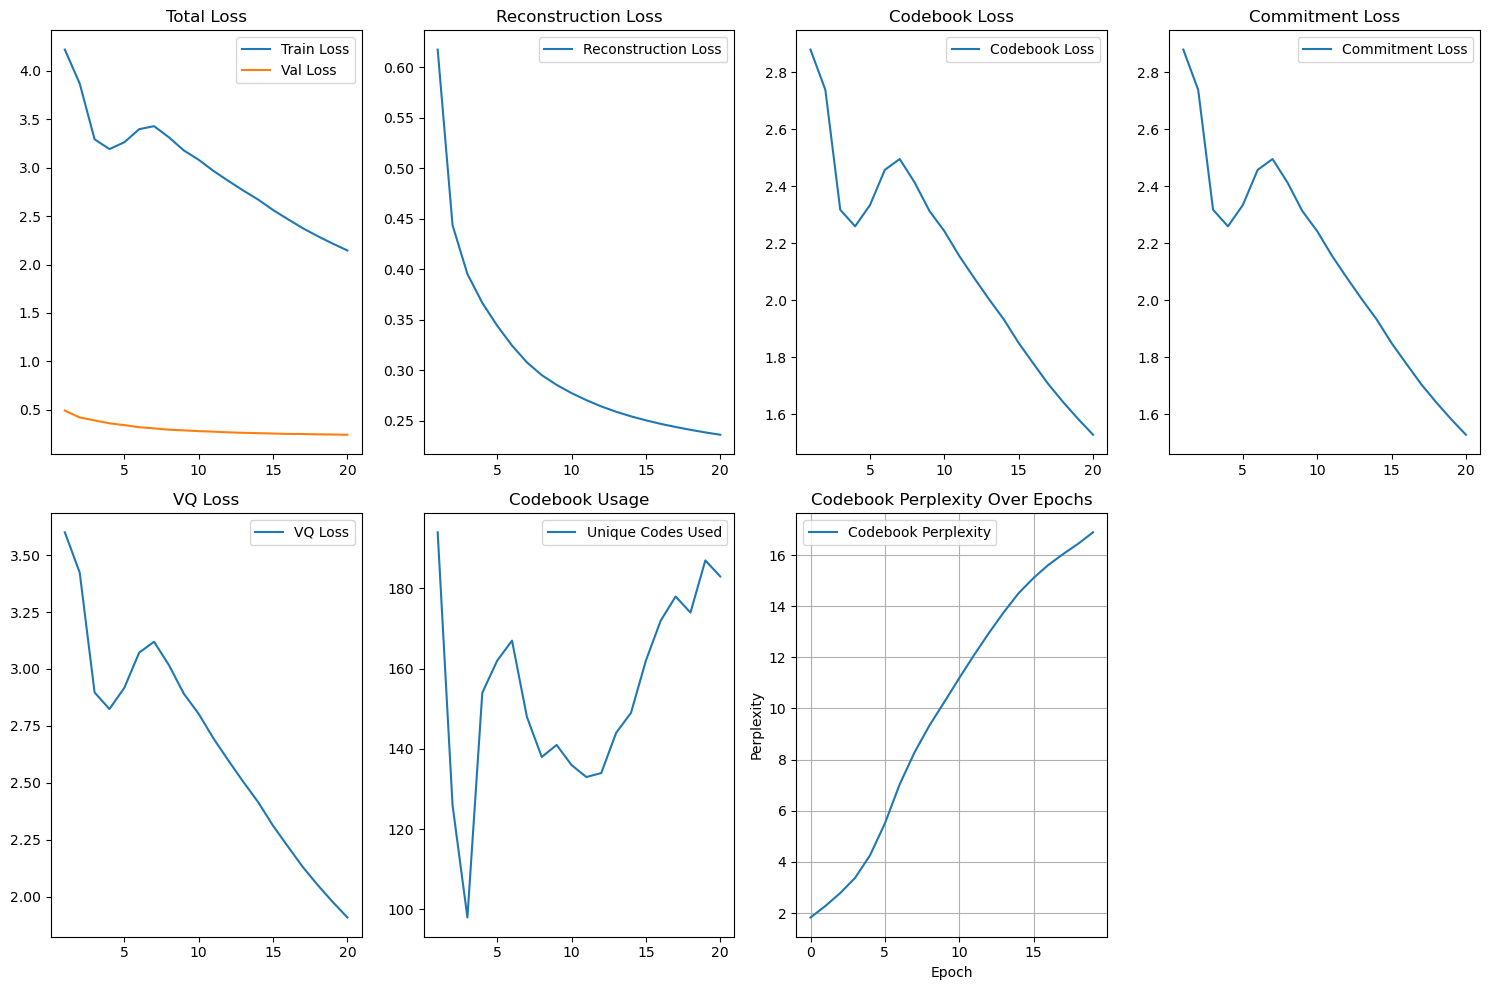

In [38]:
model = VQVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_vqvae(model, train_loader, val_loader, optimizer, epochs=20)

In [ ]:
# torch.save(model.state_dict(), "model pt files/vqvae_model.pth")

C:\Users\kiran\AppData\Local\Temp\ipykernel_22988\3358347637.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model pt files/vqvae_model

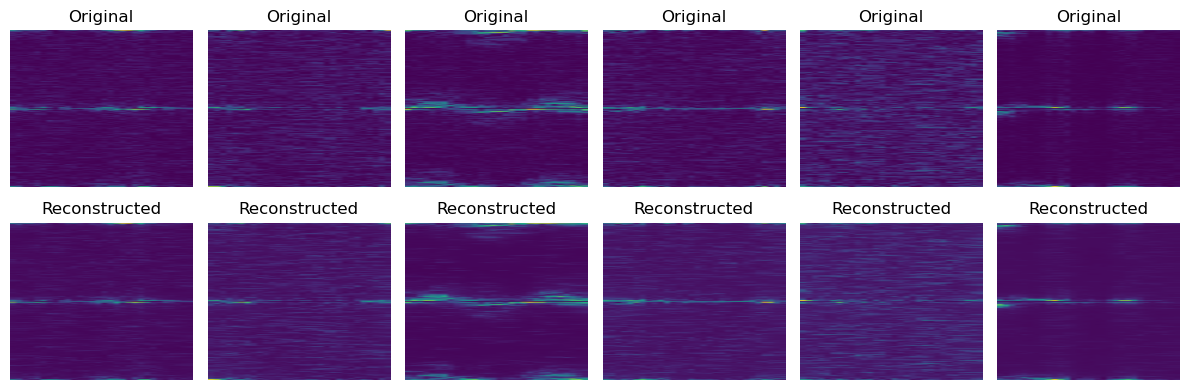

In [62]:
# Define the model again (same config as used during training)
model = VQVAE(in_channels=1, embedding_dim=128, num_embeddings=512, beta=0.25)
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch from the validation loader
device = next(model.parameters()).device
val_iter = iter(test_loader)
batch = next(val_iter).to(device)

# Run the model
with torch.no_grad():
    output = model(batch)
    recon = output["recon_x"]

# Plot original and reconstructed images
n = min(6, batch.size(0))  # number of samples to show
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(batch[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.savefig("output_images/ReconstructionExamples.png")
plt.show()

# Average Latent Space Representation

In [63]:
def validate_chunks(chunks):
    for i, chunk in enumerate(chunks):
        if chunk['exp_no'].nunique() != 1 or chunk['activity'].nunique() != 1:
            raise ValueError(f"Chunk {i} contains multiple exp_no or activity values.")
    print("All chunks have consistent 'exp_no' and 'activity'.")

In [64]:
def sample_chunks_by_activity(chunks, n_per_activity=5, seed=2555304):
    random.seed(seed)
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)
    
    sampled_chunks = []
    for activity, chunk_list in activity_map.items():
        sampled = random.sample(chunk_list, min(n_per_activity, len(chunk_list)))
        sampled_chunks.extend(sampled)
    return sampled_chunks

In [65]:
def chunk_to_image(chunk, channel='PWR_ch1'):
    # Safely reshape each (200,) array to (200, 1), then stack horizontally
    images = [arr.reshape(200, 1) for arr in chunk[channel].values]
    return np.hstack(images)  # Result: (200, 80)

In [66]:
def plot_chunks_as_images(chunks, cmap='inferno'):
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    for activity, chunk_list in activity_map.items():
        n = len(chunk_list)
        cols = 5
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(4 * cols, 3 * rows))
        
        for i, chunk in enumerate(chunk_list):
            img = chunk_to_image(chunk)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, aspect='auto', cmap=cmap, origin='lower')
            plt.title(f"{activity} #{i+1}")
            plt.axis('off')
        
        plt.suptitle(f"Activity: {activity}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig("output_images/Sampled Images.png")
        plt.show()


In [67]:
# Validate all chunks
validate_chunks(chunks)

All chunks have consistent 'exp_no' and 'activity'.


In [68]:
# Sample 5 chunks per activity
sampled_chunks = sample_chunks_by_activity(chunks, n_per_activity=5)

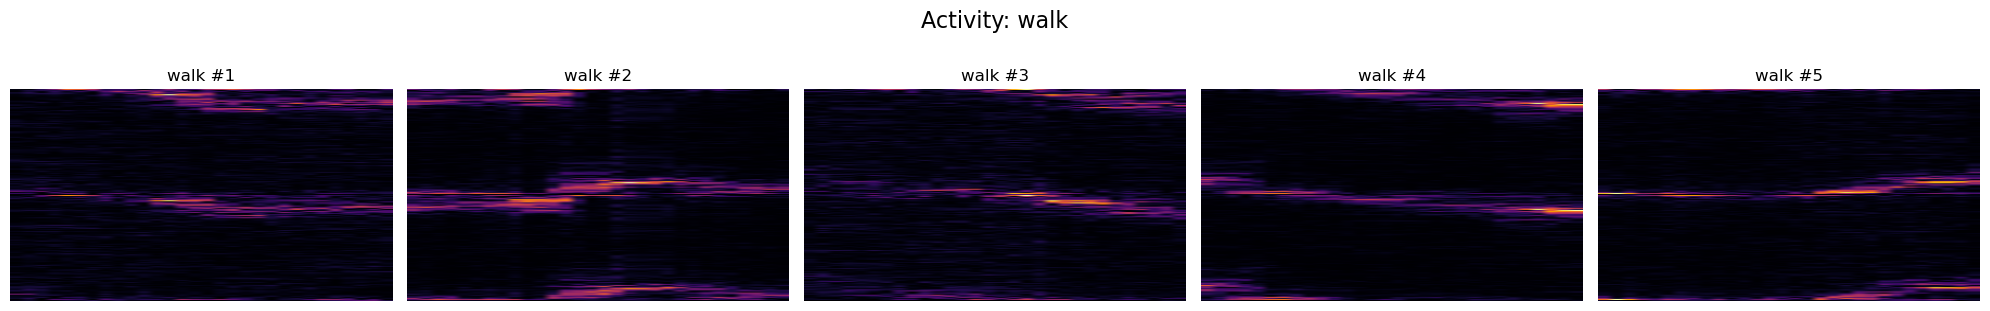

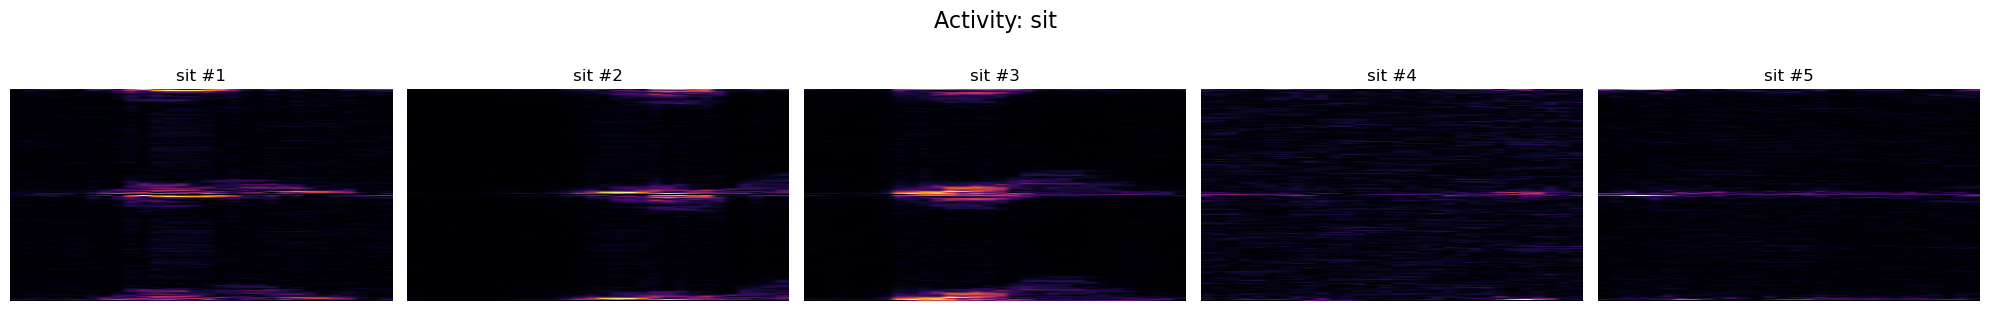

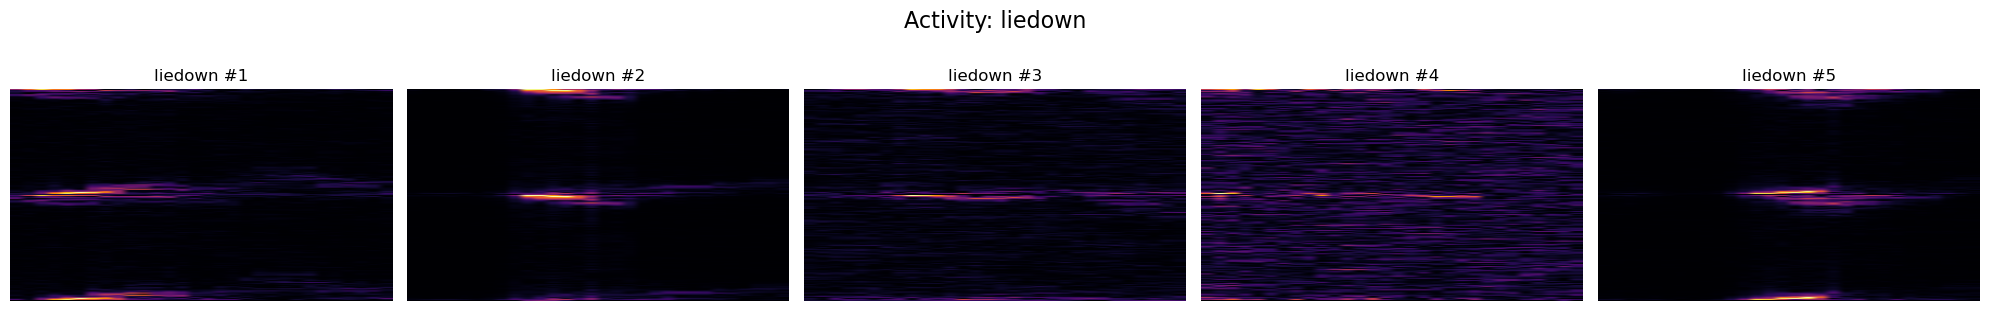

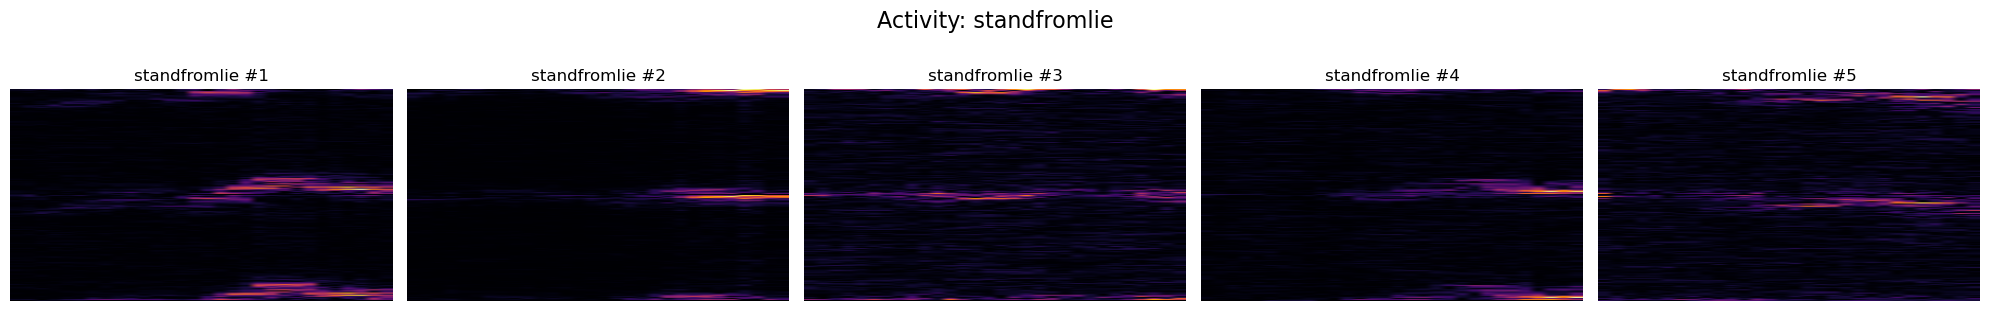

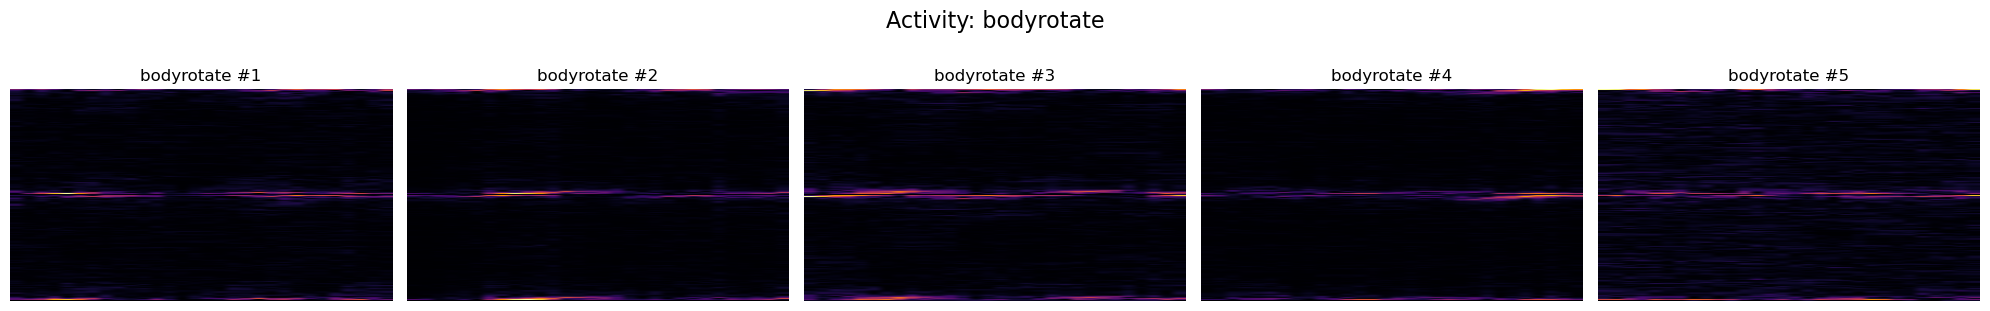

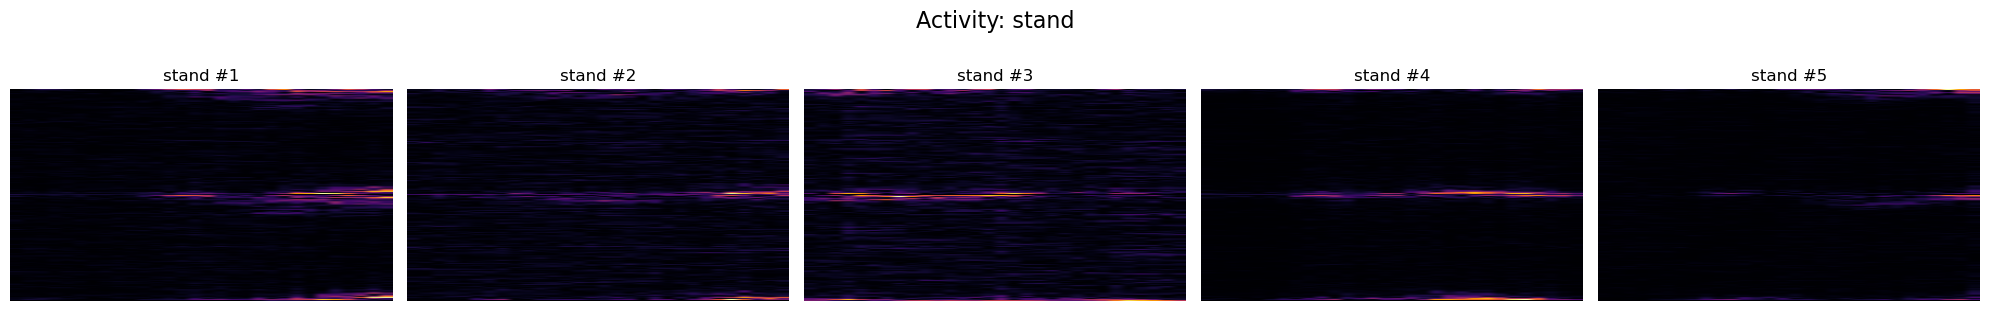

In [69]:
# Plot as images
plot_chunks_as_images(sampled_chunks)

In [70]:
def count_chunks_by_activity(chunks):
    activity_counts = Counter(chunk['activity'].iloc[0] for chunk in chunks)
    return activity_counts

In [71]:
activity_counts = count_chunks_by_activity(chunks)

for activity, count in activity_counts.items():
    print(f"{activity}: {count} chunks")

walk: 1149 chunks
sit: 54 chunks
liedown: 194 chunks
standfromlie: 189 chunks
bodyrotate: 763 chunks
stand: 37 chunks


In [72]:
def filter_out_class(chunks, class_to_remove='noactivity'):
    return [chunk for chunk in chunks if chunk['activity'].iloc[0] != class_to_remove]

chunks = filter_out_class(chunks, class_to_remove='noactivity')

In [73]:
# Build matrix of chunk-level features
features = []
labels = []

for chunk in chunks:
    # Convert each list in 'PWR_ch1' column into a single vector
    # e.g., mean over rows, or flatten if consistent shape
    power_data = np.stack(chunk['PWR_ch1'].values)  # shape: (chunk_size, signal_len)
    pooled = power_data.mean(axis=0)                # average across rows
    features.append(pooled)
    
    activity = chunk['activity'].iloc[0]
    labels.append(activity)

X = np.stack(features)
y = np.array(labels)


In [74]:
# Optional: PCA first to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=2555304, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)


e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [75]:
umap_model = umap.UMAP(n_components=2, random_state=2555304)
X_umap = umap_model.fit_transform(X_pca)

e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


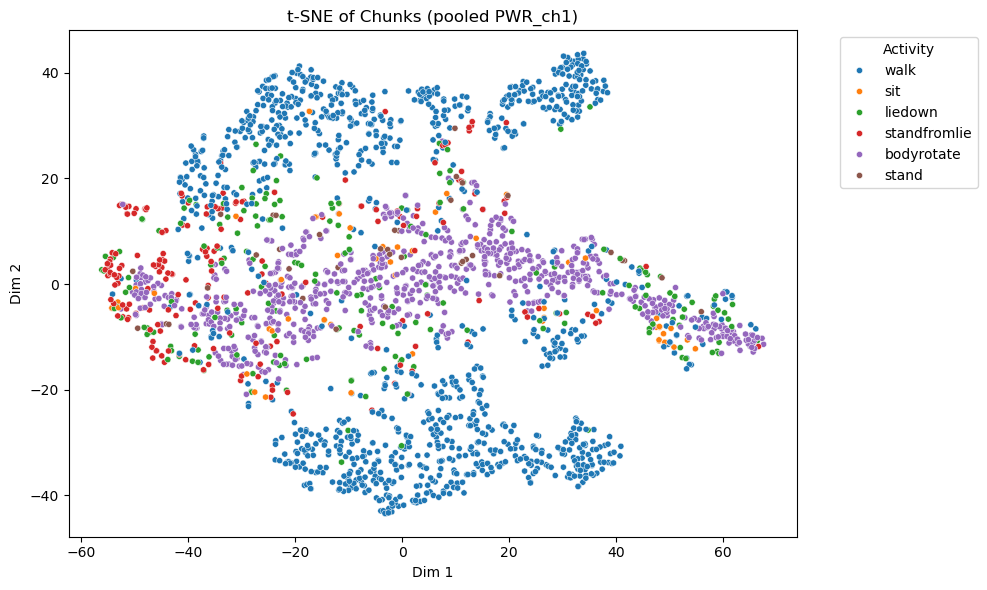

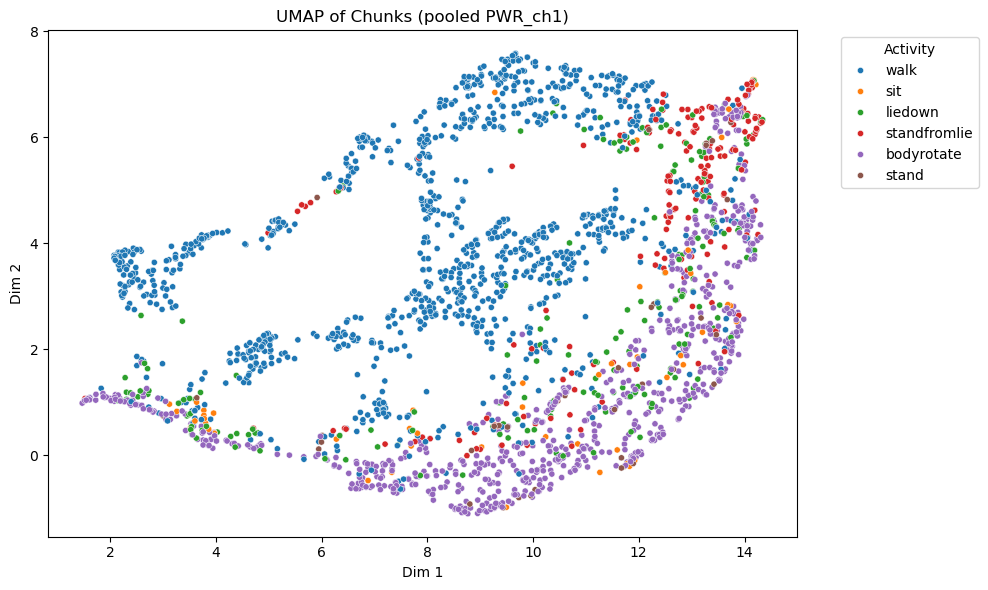

In [76]:
def plot_embedding(X_embedded, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# t-SNE plot
plot_embedding(X_tsne, y, "t-SNE of Chunks (pooled PWR_ch1)")

# UMAP plot
plot_embedding(X_umap, y, "UMAP of Chunks (pooled PWR_ch1)")


In [77]:
chunk_tensors = []
chunk_labels = []

for chunk in chunks:
    # shape: (chunk_size, signal_length)
    arr = np.stack(chunk['PWR_ch1'].values)
    tensor = torch.tensor(arr, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    chunk_tensors.append(tensor)
    chunk_labels.append(chunk['activity'].iloc[0])

In [78]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

ze_list = []
zq_list = []

with torch.no_grad():
    for tensor in chunk_tensors:
        tensor = tensor.to(device)
        z_e = model.encoder(tensor)            # (1, C, H', W')
        z_q, *_ = model.quantizer(z_e)         # (1, C, H', W')

        ze_flat = z_e.squeeze(0).cpu().numpy().reshape(-1)  # flatten to 1D
        zq_flat = z_q.squeeze(0).cpu().numpy().reshape(-1)

        ze_list.append(ze_flat)
        zq_list.append(zq_flat)


In [79]:
ze_matrix = np.stack(ze_list)
zq_matrix = np.stack(zq_list)

# PCA to reduce noise
print("Running PCA...")
pca = PCA(n_components=50)
ze_pca = pca.fit_transform(ze_matrix)
zq_pca = pca.fit_transform(zq_matrix)

# t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=2555304, perplexity=30)
ze_tsne = tsne.fit_transform(ze_pca)
zq_tsne = tsne.fit_transform(zq_pca)

# UMAP
print("Running UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=2555304)
ze_umap = umap_model.fit_transform(ze_pca)
zq_umap = umap_model.fit_transform(zq_pca)


Running PCA...
Running t-SNE...
Running UMAP...


e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
e:\AcademicsAndMiscellaneous\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


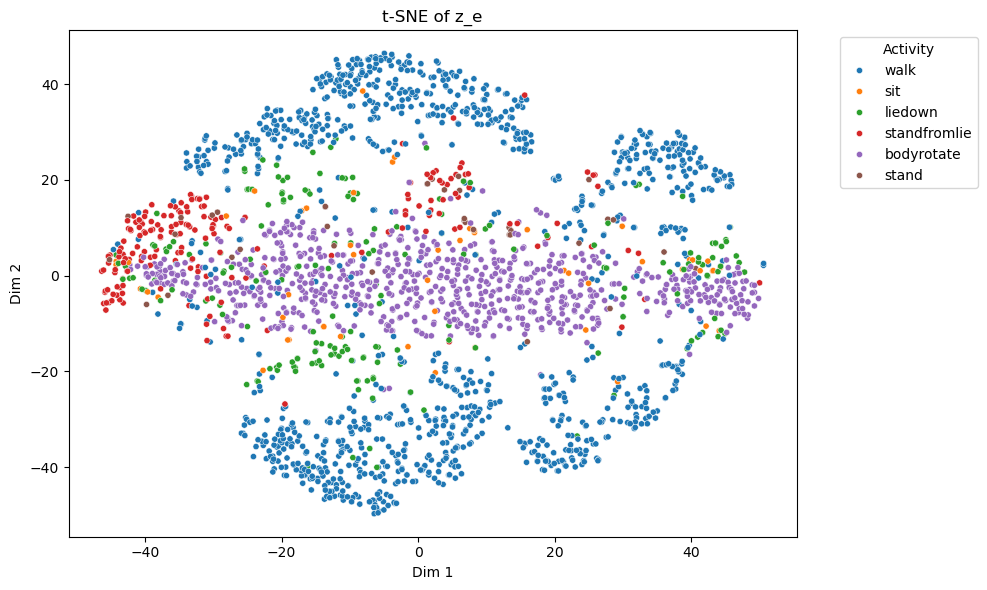

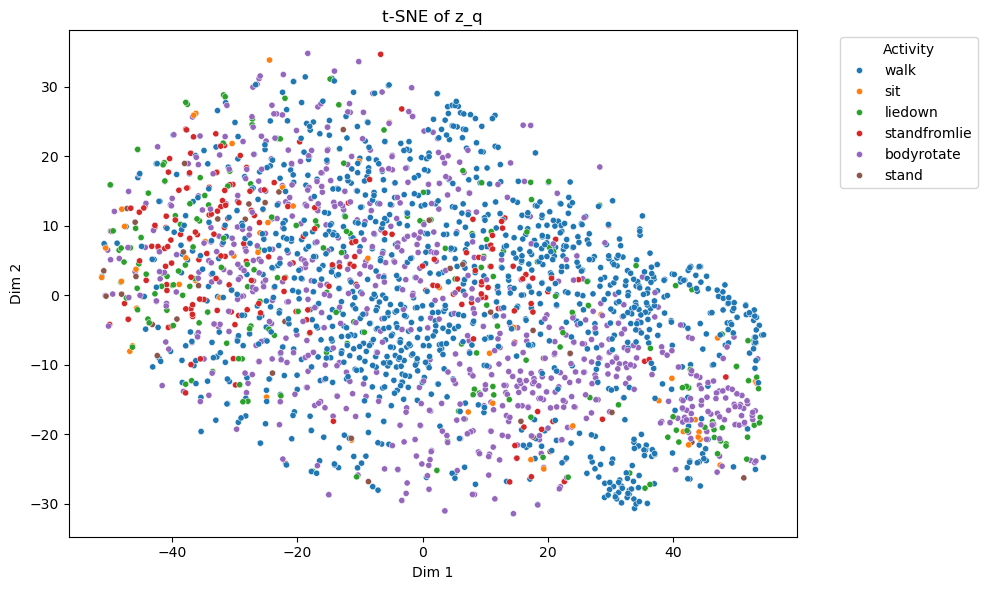

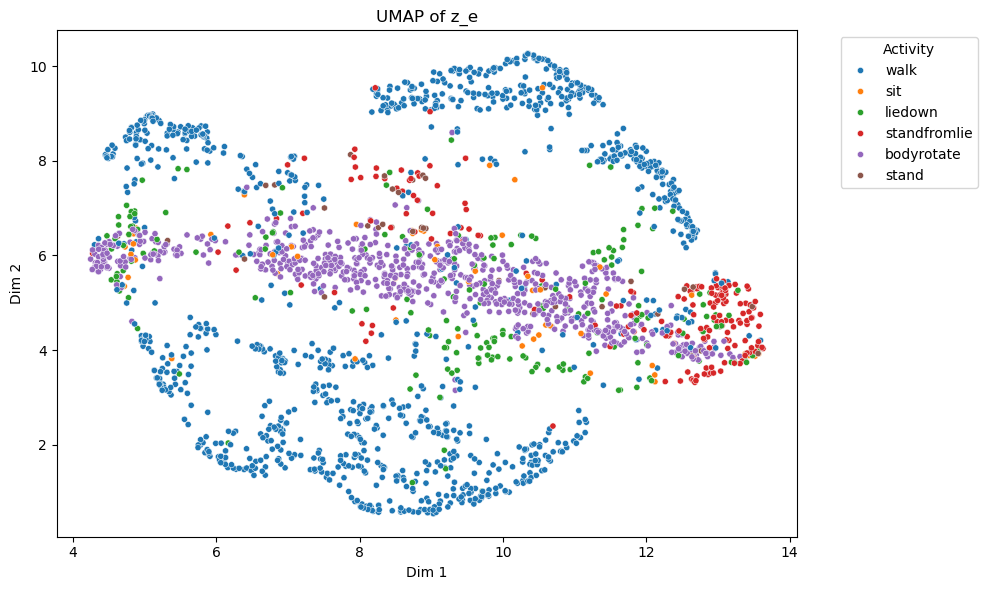

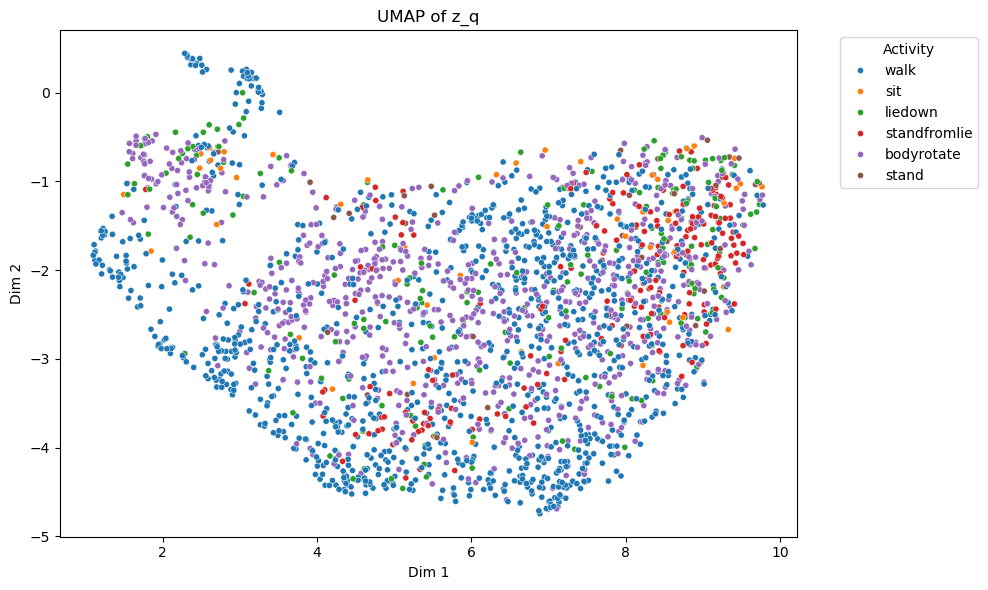

In [80]:
def plot_2d(embedding, labels, title):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot t-SNE
plot_2d(ze_tsne, chunk_labels, "t-SNE of z_e")
plot_2d(zq_tsne, chunk_labels, "t-SNE of z_q")

# Plot UMAP
plot_2d(ze_umap, chunk_labels, "UMAP of z_e")
plot_2d(zq_umap, chunk_labels, "UMAP of z_q")
